In [2]:
# Get data from Yahoo Finance
import yfinance as yf
import pandas as pd
from pandas import DataFrame

symbol = "AAPL"
interval = "15m"
period = "60d"
start_date = ""
end_date = ""


stock_data: DataFrame = yf.download(symbol, interval=interval, period=period)
selected_columns = ["Open", "High", "Low", "Close", "Volume"]
stock_data = stock_data[selected_columns].reset_index(
    drop=False)  # Put Datetime index into a column and reset index
print(stock_data)

[*********************100%%**********************]  1 of 1 completed

                Datetime        Open        High         Low       Close   
0    2023-10-30 09:30:00  169.179993  171.130005  168.869995  170.893906  \
1    2023-10-30 09:45:00  170.901505  171.169998  170.529999  170.615005   
2    2023-10-30 10:00:00  170.630005  170.899994  170.270004  170.365005   
3    2023-10-30 10:15:00  170.375000  170.449997  169.330002  169.375000   
4    2023-10-30 10:30:00  169.379898  169.985001  169.210007  169.529999   
...                  ...         ...         ...         ...         ...   
1543 2024-01-25 14:45:00  193.330002  193.600006  193.112503  193.559998   
1544 2024-01-25 15:00:00  193.550003  194.059998  193.449997  193.830002   
1545 2024-01-25 15:15:00  193.830002  194.130005  193.785995  193.853500   
1546 2024-01-25 15:30:00  193.854996  194.309998  193.800003  193.850006   
1547 2024-01-25 15:45:00  193.845001  194.199997  193.759995  194.190002   

       Volume  
0     5144322  
1     2806924  
2     2180880  
3     2506645  
4     1

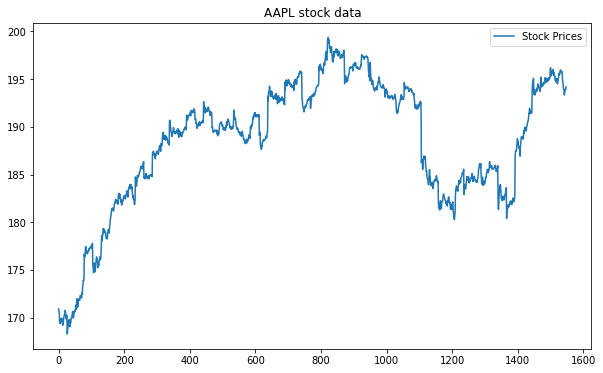

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(stock_data['Close'], label='Stock Prices')
plt.title(f'{symbol} stock data')
plt.legend()
plt.show()

In [4]:
def calculate_pivot_lookback(df, current_index, lookback, lookforward):
    """
    Calculates pivot points based on low and high values in a DataFrame.

    Parameters:
        df (DataFrame): The input DataFrame containing 'low' and 'high' columns.
        current_index (int): The index for which to calculate the pivot point.
        lookback (int): The number of periods to look back for pivot calculation.
        lookforward (int): The number of periods to look back for pivot calculation.

    Returns:
        int: A code representing the pivot point type:
            0 - No pivot point
            1 - Low pivot
            2 - High pivot
            3 - Both low and high pivot
    """
    if current_index - lookback < 0 or current_index + lookforward >= len(df):
        # Invalid index for pivot calculation
        return 0

    # Check if current index value is lower than all the other lows in the lookback and lookforward
    is_low_pivot = True
    is_high_pivot = True

    for i in range(current_index - lookback, current_index + lookforward + 1):
        if df["Low"][current_index] > df["Low"][i]:
            is_low_pivot = False
        if df["High"][current_index] < df["High"][i]:
            is_high_pivot = False

    if is_low_pivot and is_high_pivot:
        return 3  # Both low and high pivot
    elif is_high_pivot:
        return 2  # High pivot
    elif is_low_pivot:
        return 1  # Low pivot
    else:
        return 0  # No pivot point


# Applies pivot function to DF
stock_data["pivot"] = stock_data.apply(
    lambda x: calculate_pivot_lookback(stock_data, x.name, 10, 10), axis=1)
print(stock_data["pivot"].value_counts())

pivot
0    1451
2      52
1      45
Name: count, dtype: int64


In [5]:
import numpy as np


def pointpos(row):
    if row['pivot'] == 1:
        return row['Low']-1e-3
    elif row['pivot'] == 2:
        return row['High']+1e-3
    else:
        return np.nan


stock_data['pointpos'] = stock_data.apply(lambda row: pointpos(row), axis=1)
print(stock_data["pointpos"].value_counts())

pointpos
194.400994    2
188.189002    2
169.049003    1
191.088996    1
184.941002    1
             ..
189.398994    1
190.670998    1
188.898994    1
192.930993    1
196.268502    1
Name: count, Length: 95, dtype: int64


In [6]:
import plotly.graph_objects as go


dfpl = stock_data[-200:-1]
dtick = 20


dateFormat = dfpl['Datetime'].dt.strftime('%d %b %H:%M')
scatter_trace = go.Scatter(x=dateFormat, y=dfpl['pointpos'], mode='markers',
                           marker=dict(color='purple'),
                           name='Pivot Points')

candlestick_trace = go.Candlestick(x=dateFormat,
                                   open=dfpl['Open'],
                                   high=dfpl['High'],
                                   low=dfpl['Low'],
                                   close=dfpl['Close'],
                                   increasing_line_color='green',
                                   decreasing_line_color='red',
                                   name='Candlestick')

layout = go.Layout(title='AAPL Chart with Pivot Points',
                   xaxis=dict(title='Date', showgrid=False,
                              type='category', dtick=dtick),
                   yaxis=dict(title='Price', showgrid=False),
                   xaxis_rangeslider_visible=False)

fig = go.Figure(data=[scatter_trace, candlestick_trace], layout=layout)



fig.show()

In [7]:
dfhis = stock_data[:]

pivot_1 = dfhis[dfhis['pivot'] == 1]
color_pivot_1 = 'rgba(0, 0, 255, 0.7)'
pivot_2 = dfhis[dfhis['pivot'] == 2]
color_pivot_2 = 'rgba(255, 0, 0, 0.7)'
nbinsx = 25
opacity = 0.8

his_trace_1 = go.Histogram(
    x=pivot_1['pointpos'], name="Support", nbinsx=nbinsx, opacity=opacity, marker_color=color_pivot_1)

his_trace_2 = go.Histogram(
    x=pivot_2['pointpos'], name="Resistanace", nbinsx=nbinsx, opacity=opacity, marker_color=color_pivot_2)

layoutHis = go.Layout(title="AAPL Support and Resistance (Last 6 Months)",barmode='overlay', xaxis=dict(title='Price'),
                      yaxis=dict(title='Frequency'))

figHis = go.Figure(data=[his_trace_1,his_trace_2], layout=layoutHis)

figHis.show()